# Visualization of "specificity" in the PRSB corpus

In [1]:
import pandas as pd
import numpy as np
import pickle
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import my_files
import my_preprocessing
from my_preprocessing import clean_text
from my_lda import MyCorpus, make_doc_path_list
import my_vis

import warnings
warnings.filterwarnings('ignore')

/home/omlean/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
# load LDA model
model_id = 'lda_25_1.0_0.002'

model_path = f'models/{model_id}.pkl'
model = my_files.load_model(model_path)

# load dictionary
dict_path = 'models/dictionary.dict'
dictionary = Dictionary.load(dict_path)

# make corpus
metadata = my_preprocessing.load_metadata()
metadata = my_preprocessing.drop_non_research(metadata) # drop articles that aren't research, e.g. volume information, obituaries
doc_path_list = ['data/txt/' + file for file in metadata.filename]
corpus = MyCorpus(doc_path_list, my_preprocessing.clean_text, dictionary=dictionary)

## Join metadata with doc_topics

In [3]:
# add path to beginning of filename in metadata
path = 'data/txt/'
metadata['filename'] = metadata['filename'].apply(lambda x: path + x)
metadata = metadata.set_index('filename')
print(f'Number of docs in metadata: {len(metadata)}')

Number of docs in metadata: 15092


## Label topics

In [4]:
def label_topics(model):
    """A quick way to view top terms in a topic and input a label for the topic based on those terms."""
    num_topics = model.get_topics().shape[0]
    topic_labels = {}
    for i in range(num_topics):
        words = [word for word,value in model.show_topic(i, topn=20)]
        topic_labels[str(i)] = f'{i}: {input(prompt=words)}'
    return topic_labels

In [5]:
# # input manually and save
# dt_path = f'models/{model_id}_doc_topics.csv.gz'
# doc_topics = pd.read_csv(dt_path, index_col=0, compression='gzip')
# doc_topics.rename(columns=label_topics(model), inplace=True)
# doc_topics.to_csv(dt_path, compression='gzip')

In [6]:
# load previously labelled doc_topics file
dt_path = f'models/{model_id}_doc_topics.csv.gz'
doc_topics = pd.read_csv(dt_path, index_col=0, compression='gzip')

In [7]:
# join dataframes on filename
df = metadata.join(doc_topics)
print(len(df))

15092


## Correlations between topics
Are some topics likely to be found together in documents?

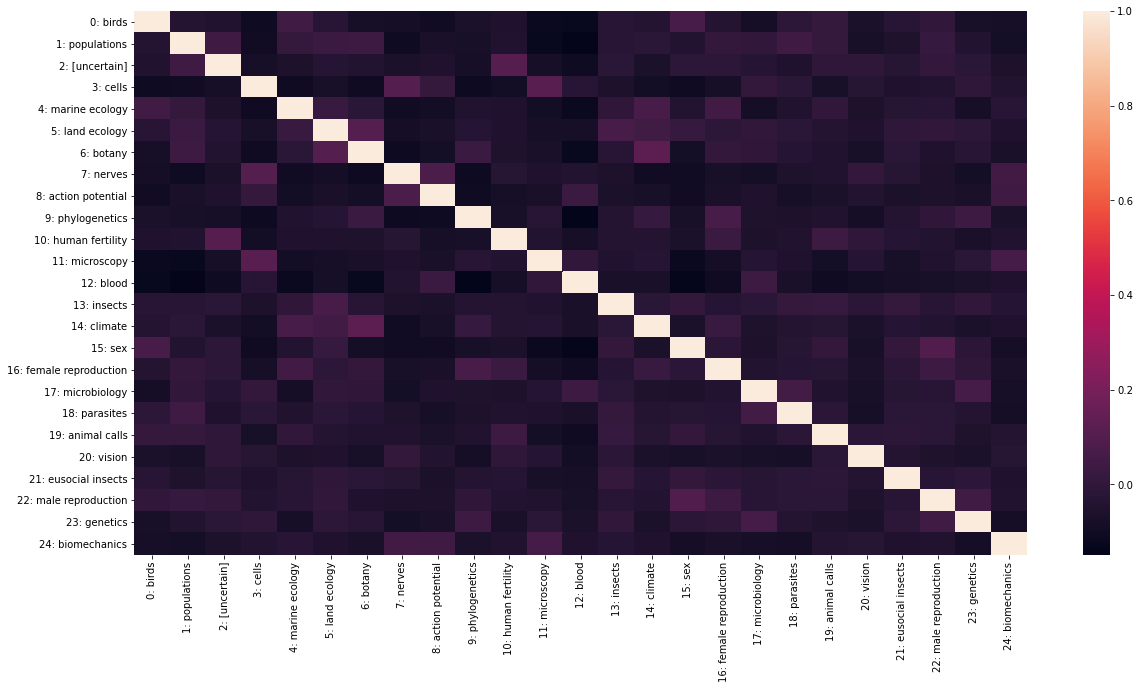

In [8]:
topic_cols = [col for col in df.columns if ': ' in col] # picks out topic columns

topics_df = df[topic_cols]

plt.figure(figsize=(20,10))
sns.heatmap(topics_df.corr())

No significant correlations.

## Topics over time

In [9]:
# sort by year
num_topics = model.get_topics().shape[0]
df_topic_years = df.groupby('year')[topic_cols].mean()
df_topic_years.head()

0: birds  1: populations  2: [uncertain]  3: cells  4: marine ecology  \
year                                                                          
1905  0.003665        0.006201        0.011179  0.063319           0.006374   
1906  0.006996        0.004698        0.011983  0.105758           0.004623   
1907  0.000741        0.000196        0.014947  0.084249           0.002182   
1908  0.009134        0.001792        0.011049  0.056251           0.002881   
1909  0.006970        0.007596        0.023972  0.053269           0.005796   

      5: land ecology  6: botany  7: nerves  8: action potential  \
year                                                               
1905         0.003000   0.009597   0.083294             0.030059   
1906         0.003707   0.012096   0.097189             0.030467   
1907         0.002283   0.006106   0.103971             0.036845   
1908         0.002637   0.005571   0.163191             0.019059   
1909         0.001786   0.011893   0.062579             0.052548   

      9: phylogenetics  ...   15: sex  16: female reproduction  \
year                    ...                                      
1905          0.004635  ...  0.003177                 0.003180   
1906          0.005868  ...  0.006518                 0.001553   
1907          0.001733  ...  0.002030                 0.003177   
1908          0.005217  ...  0.002372                 0.000560   
1909          0.007529  ...  0.005076                 0.000390   

      17: microbiology  18: parasites  19: animal calls  20: vision  \
year                                                                  
1905          0.012557       0.040883          0.007963    0.038767   
1906          0.022299       0.027467          0.005644    0.010275   
1907          0.026365       0.030494          0.002365    0.016766   
1908          0.004240       0.048526          0.003861    0.012234   
1909          0.015915       0.084364          0.009792    0.014047   

      21: eusocial insects  22: male reproduction  23: genetics  \
year                                                              
1905              0.008438               0.002288      0.014660   
1906              0.004595               0.007613      0.017382   
1907              0.003778               0.001210      0.016263   
1908              0.001539               0.028442      0.007158   
1909              0.002242               0.016999      0.015727   

      24: biomechanics  
year                    
1905          0.060153  
1906          0.053114  
1907          0.077669  
1908          0.057390  
1909          0.040555  

[5 rows x 25 columns]

[Plotly documentation](https://plotly.com/python/filled-area-plots/)

In [10]:
# create list of topic words for hover info
topic_list_list = []
for i in range(num_topics):
    topics = model.show_topic(i, topn=12)
    topic_list = ', '.join([word for word, prob in topics])
    topic_list_list.append(topic_list)

In [11]:
fig = go.Figure()

x = df_topic_years.index

for i in range(len(topic_cols)):
    y = df_topic_years[topic_cols[i]]
    fig.add_trace(go.Scatter(
        x=x, y=y,
        text=topic_list_list[i],
        hoveron='points+fills',
        hoverinfo='name + text',
        mode='lines',
        name=topic_cols[i],
        line=dict(width=0.5),
        stackgroup='one',
        groupnorm='percent'
    ))

# fig.update_traces(selector=dict(type='scatter'))

fig.show()

In [12]:
# # write to html
# fig.write_html('results/topics_over_time.html')

## Topic profiles of documents containing "specificity"

- Do papers containing "specificity" cluster in the topic space?

In [13]:
# # spec_metadata = metadata[metadata]
# def contains_word(path, word, clean_function, prefix=''):
#     path = prefix+path
#     text = my_files.get_text(path)
#     text = clean_function(text)
#     return word in text

# mask = []
# for path in tqdm(metadata.index.tolist()):
#     mask.append(contains_word(path, 'specificity', clean_text))

In [14]:
# # add column to df and save to csv
# df['contains_spec'] = mask
# df.to_csv('data/metadata_topics_specificity.csv.gz', sep='\t', compression='gzip')

In [15]:
# load previously saved csv
df = pd.read_csv('data/metadata_topics_specificity.csv.gz', sep='\t', compression='gzip')
len(df)

15092

In [16]:
df.head()

filename  jstor-id  \
0  data/txt/journal-article-10.2307_1353811.txt   1353811   
1  data/txt/journal-article-10.2307_1353812.txt   1353812   
2  data/txt/journal-article-10.2307_1353813.txt   1353813   
3  data/txt/journal-article-10.2307_1353814.txt   1353814   
4  data/txt/journal-article-10.2307_1353815.txt   1353815   

                                               title  \
0                                    Knowing No Fear   
1  Anti-Predator Behaviour Changes Following an A...   
2  Regulation of Queen-Worker Conflict in Bumble-...   
3  An Uncoupling of Male and Sexual Egg Productio...   
4  Sex Differences in Energy Expenditure in Non-H...   

                                             authors  year  month  volume  \
0  Sprengelmeyer, Reiner; Young, Andrew W.; Schro...  1999     12     266   
1                                Díaz-Uriarte, Ramón  1999     12     266   
2                                         Bloch, Guy  1999     12     266   
3                de Meester, Luc; Vanoverbeke, Joost  1999     12     266   
4                     Key, Catherine; Ross, Caroline  1999     12     266   

  issue      pages                                           keywords  ...  \
0  1437  2451-2456  Amygdala; Facial expression; Emotion recogniti...  ...   
1  1437  2457-2464  Anti-predator behaviour; Predation risk; Aggre...  ...   
2  1437  2465-2469  Social evolution; Bumble-bees; Reproduction; Q...  ...   
3  1437  2471-2477  Seasonality; Inbreeding; Mating patterns; Cycl...  ...   
4  1437  2479-2485  Energy expenditure; Sexual dimorphism; Activit...  ...   

         16   17        18        19        20        21        22        23  \
0  0.000000  0.0  0.000000  0.065114  0.055192  0.000000  0.000000  0.000000   
1  0.000000  0.0  0.000000  0.345898  0.000000  0.010597  0.000000  0.000000   
2  0.000000  0.0  0.000000  0.000000  0.000000  0.909142  0.000000  0.000000   
3  0.248908  0.0  0.277461  0.000000  0.000000  0.000000  0.039686  0.048267   
4  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

         24  contains_spec  
0  0.000000          False  
1  0.000000          False  
2  0.000000          False  
3  0.000000          False  
4  0.031147          False  

[5 rows x 38 columns]

[Text(0, 0, 'PC1'),
 Text(0, 0, 'PC2'),
 Text(0, 0, 'PC3'),
 Text(0, 0, 'PC4'),
 Text(0, 0, 'PC5'),
 Text(0, 0, 'PC6'),
 Text(0, 0, 'PC7'),
 Text(0, 0, 'PC8'),
 Text(0, 0, 'PC9'),
 Text(0, 0, 'PC10'),
 Text(0, 0, 'PC11'),
 Text(0, 0, 'PC12'),
 Text(0, 0, 'PC13'),
 Text(0, 0, 'PC14'),
 Text(0, 0, 'PC15'),
 Text(0, 0, 'PC16'),
 Text(0, 0, 'PC17'),
 Text(0, 0, 'PC18'),
 Text(0, 0, 'PC19'),
 Text(0, 0, 'PC20'),
 Text(0, 0, 'PC21'),
 Text(0, 0, 'PC22'),
 Text(0, 0, 'PC23'),
 Text(0, 0, 'PC24'),
 Text(0, 0, 'PC25')]

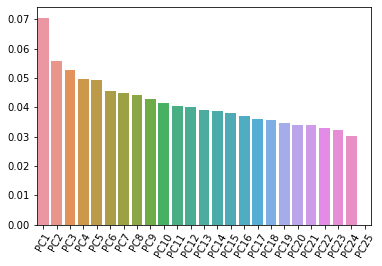

In [17]:
# Project onto two dimensions using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

topic_cols = [str(i) for i in range(num_topics)]
data = df[topic_cols].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# visualise explained variance with scree plot
y = pca.explained_variance_ratio_
x = [f'PC{i}' for i in range(1, len(y)+1)]
fig = sns.barplot(x=x, y=y)
fig.set_xticklabels(rotation=60, labels=x)

In [18]:
first_3_pcs = sum(pca.explained_variance_ratio_[:3])
print(f"The first three PCs explain {first_3_pcs*100}% of the variance")

The first three PCs explain 17.926748894449894% of the variance


Given the scree plot, it's worth plotting in 3D to save the third principal component.

In [19]:
data = df[topic_cols].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

In [20]:
import plotly.express as px
fig = px.scatter_3d(df, x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2],
                    color=df.contains_spec)
fig.update_traces(marker=dict(size=2))
fig.show()

From this plot, it looks as though papers containing "specificity" are quite evenly distributed in the parameter space. This is suprising, but perhaps this isn't the best visualization to reveal non-homogeneity.

In [21]:
# # write to html (uncomment if needed)
# fig.write_html('results/all_papers_pca.html')

#### Plot in 2d

In [22]:
# Reduce to 2 Principal Components
data = df[topic_cols].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

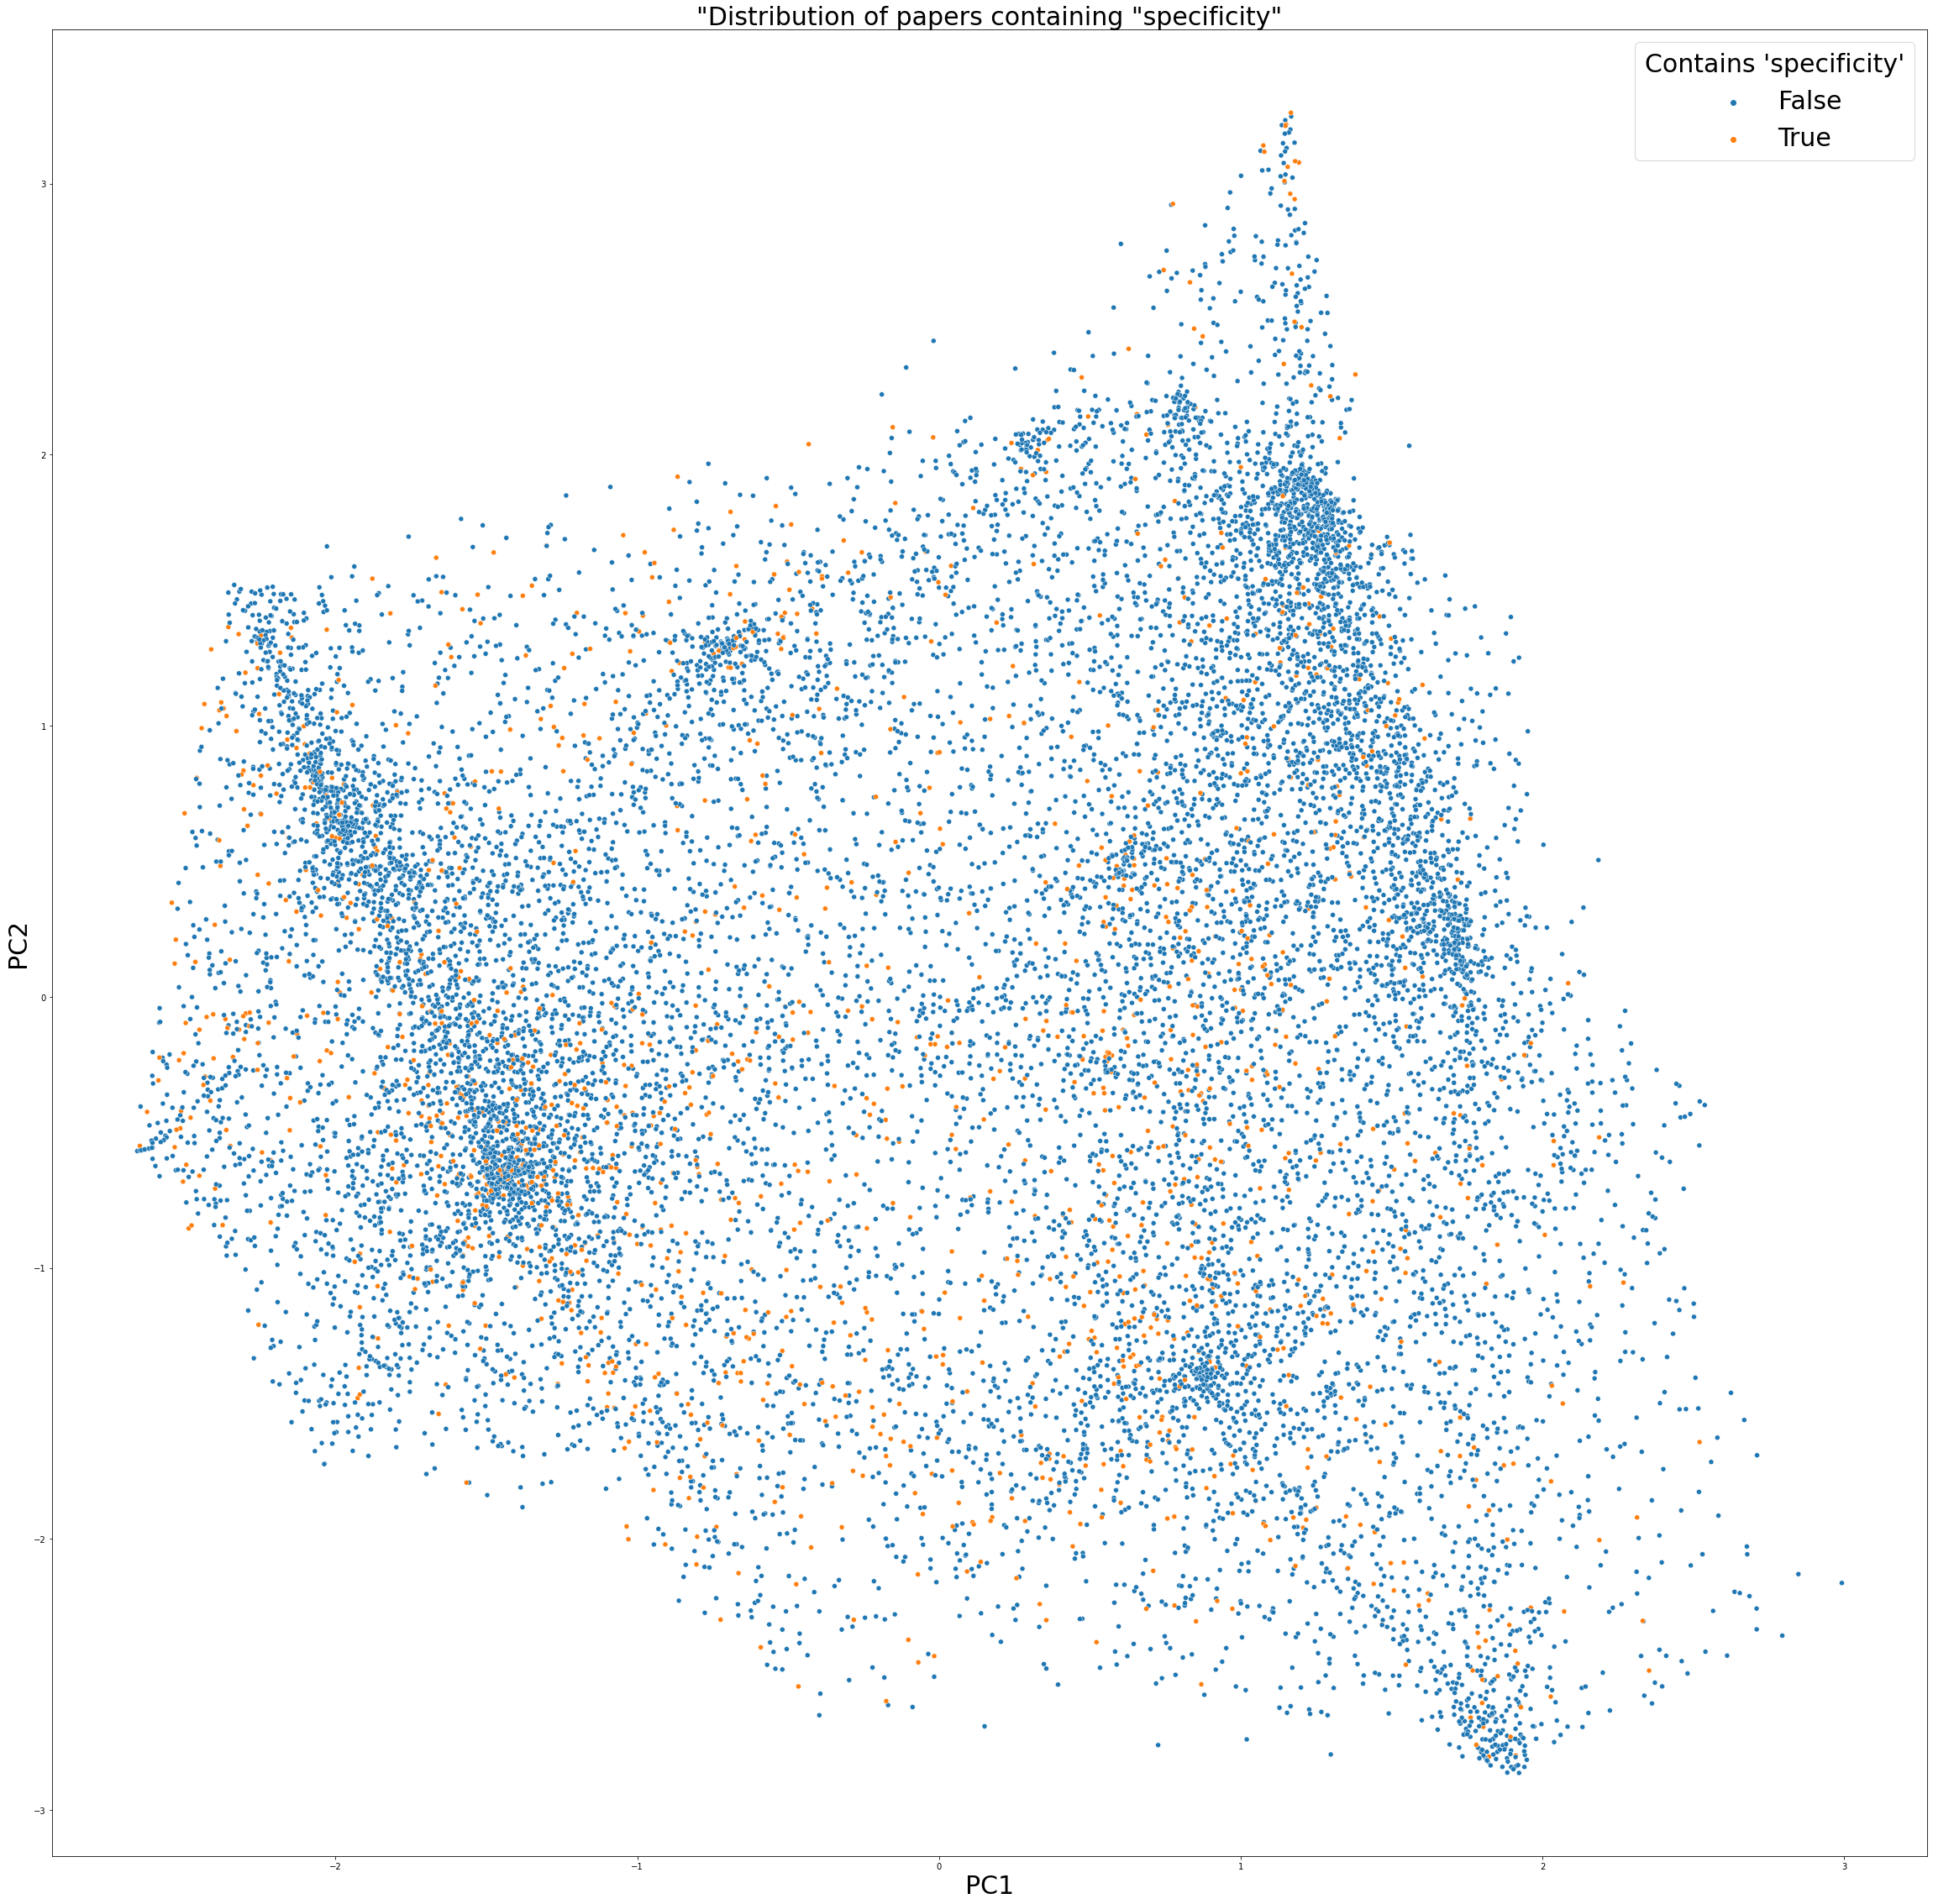

In [23]:
# plot in 2d
plt.figure(figsize=(40,40))
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=df.contains_spec.to_numpy())
plt.title('"Distribution of papers containing "specificity"', size=30)
plt.xlabel("PC1", size=30)
plt.ylabel("PC2", size=30)
plt.legend(title="Contains 'specificity'", prop={'size': 30}, title_fontsize=30)

## Visualization of papers containing "specificity"

- Do documents containing "specificity" cluster together in the topic space?

In [24]:
df_spec = df[df.contains_spec]
len(df_spec)

1472

#### K means clustering

In [25]:
# elbow plot

from sklearn.cluster import KMeans

data = df_spec[topic_cols].to_numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

Ks = list(range(1,21))
inertia_values = []
for k in Ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_scaled)
    inertia_values.append(kmeans.inertia_)
    

([<matplotlib.axis.XTick at 0x7f73f754d6d0>,
 <a list of 20 Text major ticklabel objects>)

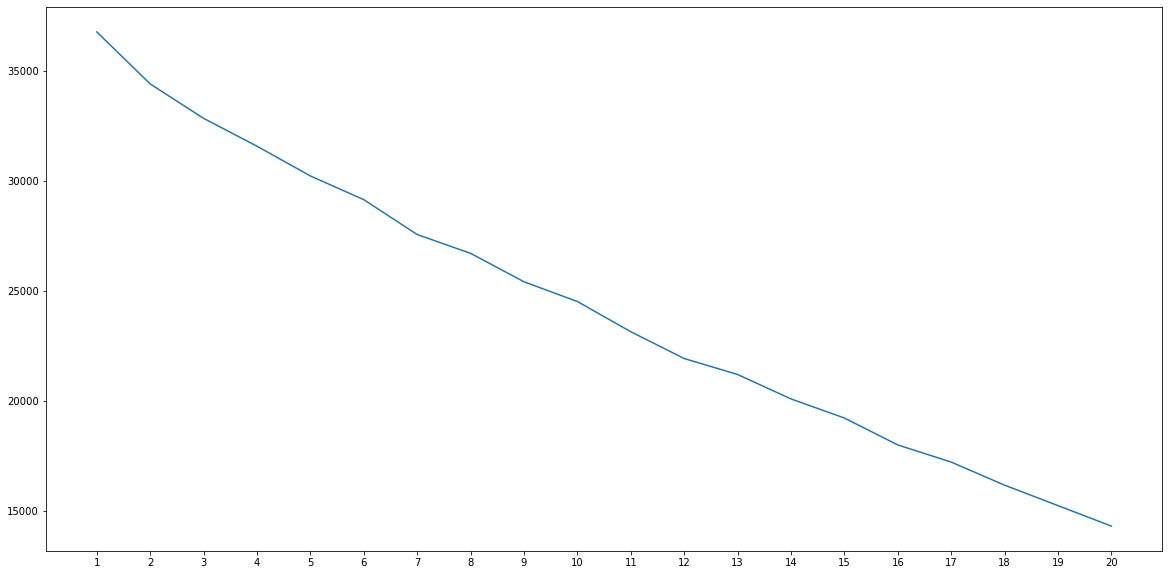

In [26]:
plt.figure(figsize=(20,10))
fig = plt.plot(Ks, inertia_values)
plt.xticks(Ks)

No noticeable elbow

## Co-occurence of "specificity" with conceptually related words in topics: 

### 1. "affinity"

In [27]:
df = metadata.join(doc_topics)
wordlist = ['specificity', 'affinity']

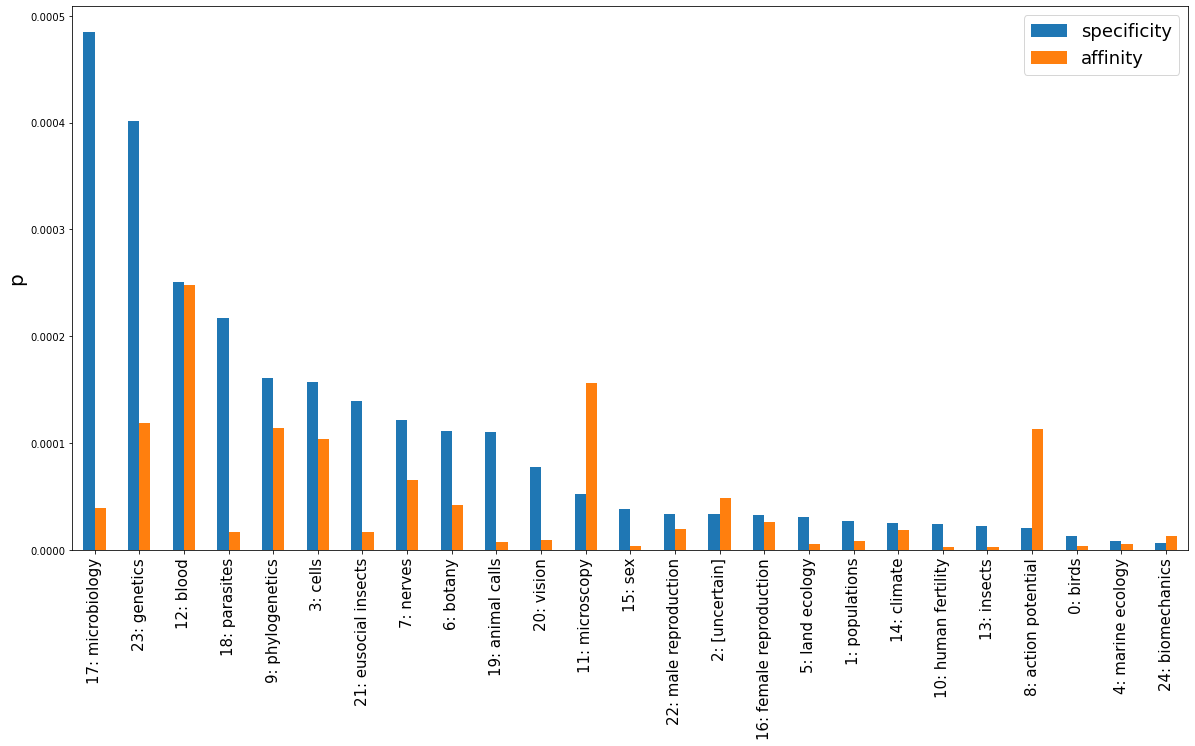

In [28]:
my_vis.word_compare(df, wordlist, model, dictionary)

### 2. "binding"

In [29]:
wordlist = ['specificity', 'binding']

word_compare(df, wordlist, model, dictionary)

NameError: name 'word_compare' is not defined

### 3. "selectivity"

In [ ]:
wordlist = ['specificity', 'selectivity']

word_compare(df, wordlist, model, dictionary)